In [39]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [40]:
dataset_PT = TSD(categories=['sc'], file_path="../datasets/PT_dataset_imputed.csv")

Dataset loaded from ../datasets/PT_dataset_imputed.xlsx


In [47]:
scale_cols = ['Pop','Terr','Cap','Hierarchy']
non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money','MSP']
input_cols = scale_cols + non_scale_cols
crisis_cols = ['overturn', 'predecessor_assassination', 'intra_elite',
       'military_revolt', 'popular_uprising', 'separatist_rebellion',
       'external_invasion', 'external_interference']
for col in crisis_cols:
    dataset_PT.scv_imputed[col] = np.nan
for ind, row in dataset_PT.scv_imputed.iterrows():
    for col in crisis_cols:
        try:
            col_value = dataset_PT.scv.loc[(dataset_PT.scv.PolityID == row.PolityID)&(dataset_PT.scv.Year == row.Year), col].values[0]
        except:
            print(row.PolityID, row.Year)
            continue
        dataset_PT.scv_imputed.loc[ind, col] = col_value

In [48]:
dataset_PT.scv_imputed[crisis_cols] = dataset_PT.scv_imputed[crisis_cols].fillna(0)
dataset_PT.scv_imputed.dropna(subset=input_cols, inplace=True)
dataset_PT.scv_imputed.reset_index(drop=True, inplace=True)
dataset_PT.scv_imputed.columns

Index(['NGA', 'PolityID', 'PolityName', 'Year', 'Pop', 'Terr', 'Cap',
       'Hierarchy', 'Hierarchy_sq', 'Government', 'Infrastructure',
       'Information', 'Money', 'dataset', 'MSP', 'Crisis', 'Scale_1', 'Inst_1',
       'Comp', 'overturn', 'predecessor_assassination', 'intra_elite',
       'military_revolt', 'popular_uprising', 'separatist_rebellion',
       'external_invasion', 'external_interference'],
      dtype='object')

              precision    recall  f1-score   support

           0       0.51      0.44      0.47        98
           1       0.38      0.17      0.23        65
           2       0.52      0.52      0.52       100
           3       0.43      0.24      0.31        50
           4       0.55      0.40      0.46        15
           5       0.00      0.00      0.00        12
           6       0.53      0.19      0.28        42
           7       0.00      0.00      0.00        29

   micro avg       0.49      0.32      0.39       411
   macro avg       0.36      0.24      0.28       411
weighted avg       0.43      0.32      0.36       411
 samples avg       0.20      0.16      0.16       411

Feature ranking:
1. feature 0 (0.536700)
2. feature 1 (0.463300)


/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to con

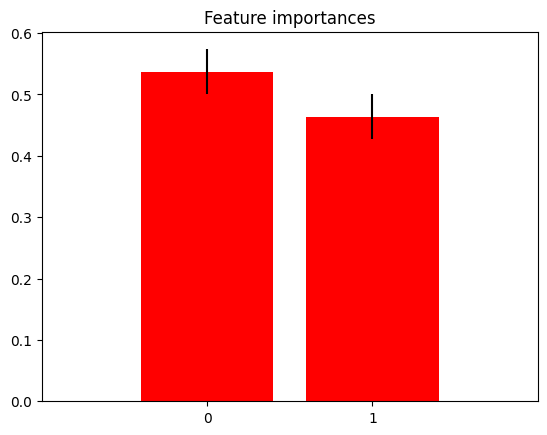

In [51]:
input_cols = ['Scale_1','Inst_1']
df_x = dataset_PT.scv_imputed[input_cols]
df_y = dataset_PT.scv_imputed[crisis_cols]
df_y = df_y.astype(int)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test, rfc_pred))
# print(confusion_matrix(y_test, rfc_pred))

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [50]:
input_cols

['Pop',
 'Terr',
 'Cap',
 'Hierarchy',
 'Government',
 'Infrastructure',
 'Information',
 'Money',
 'MSP']